# Import des modules et récupération des données Titanic

In [1]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import xgboost as xgb

train = pd.read_csv("../titanic/data/train.csv")
test = pd.read_csv("../titanic/data/test.csv")

# Préparation des données (simple)

In [2]:
def dataprep(data):
    sexe = pd.get_dummies(data['Sex'], prefix='sex')
    cabin = pd.get_dummies(data['Cabin'].fillna('X').str[0], prefix='Cabin')
    # Age 
    age = data['Age'].fillna(data['Age'].mean())
    emb = pd.get_dummies(data['Embarked'], prefix='emb')
    # Prix du billet / Attention une donnée de test n'a pas de Prix !
    faresc = pd.DataFrame(MinMaxScaler().fit_transform(data[['Fare']].fillna(0)), columns = ['Prix'])
    # Classe
    pc = pd.DataFrame(MinMaxScaler().fit_transform(data[['Pclass']]), columns = ['Classe'])
    
    dp = data[['SibSp']].join(pc).join(sexe).join(emb).join(faresc).join(cabin).join(age)
    return dp

## Préparation à l'entrainement

In [3]:
Xtrain = dataprep(train)
Xtest = dataprep(test)
y = train.Survived

# Utilisation de XGBoost via scikit-learn

In [4]:
boost = XGBClassifier()
boost.fit(Xtrain, y)
p_boost = boost.predict(Xtrain)
print ("Score Train -->", round(boost.score(Xtrain, y) *100,2), " %")

Score Train --> 87.32  %


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## importance des features

In [5]:
xgb.plot_importance(boost)

## Affichage des résultats (via matplotloib & graphviz)

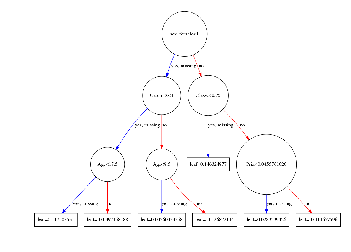

In [6]:
# Installer le module graphviz
# via pip install graphviz
# + sudo apt-get install graphviz
xgb.plot_tree(boost, num_trees=2)

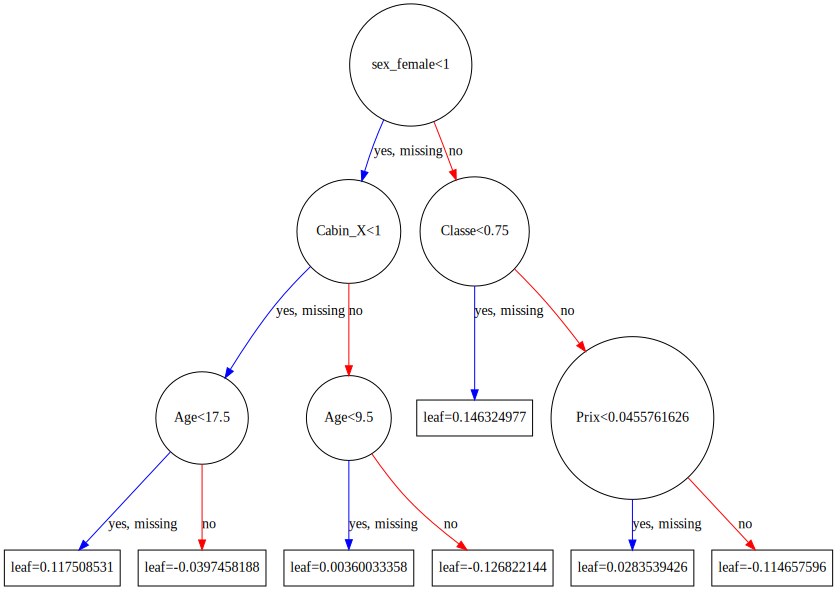

In [7]:
xgb.to_graphviz(boost, num_trees=2)

# Sauvegarde du modèle

In [12]:
boost._Booster.save_model('titanic.xbmodel')

# Chargement d'un modèle existant

In [ ]:
boost = xgb.Booster({'nthread': 4})  # init model
boost.load_model('titanic.xbmodel')  # load data

# Utilisation sans scikit-learn

In [ ]:
num_round = 10
params = {'max_depth': 2, 
          'eta': 1, 
          'silent': 1, 
          'objective': 'binary:logistic'}
params['nthread'] = 4
params['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

boost2 = xgb.train(params, Xtrain, num_round, evallist)